In [1]:
import torch
from torch import nn, optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
blockSize = 32

In [3]:
def sanitize_string(s):
    # remove every non-alpha character
    sanitized = ''.join(c for c in s.lower() if c.isalpha())
    return sanitized.lower()

In [4]:
def toWindows(s, blockSize=blockSize):
    i = 0
    out = []
    while i < len(s)-blockSize:
        block = s[i:i+blockSize]
        i += 1
        out.append(block)
    return out


In [5]:
from qwerty_map import keyboard_layout, dist, max_dist
def str_to_neurons(s):
    # convert string to list of neurons
    usage_data = {}
    for c in s:
        if c not in usage_data:
            usage_data[c] = 0
        usage_data[c]+=1
    for c in usage_data:
        usage_data[c] = usage_data[c] / len(s)
    neurons = np.zeros(ord('z') - ord('a') + 1 + len(s))
    for c in range(ord('a'), ord('z') + 1):
        if chr(c) in usage_data:
            neurons[c - ord('a')] = usage_data[chr(c)]
    last_char = s[0]
    i = ord('z')- ord('a') + 1
    for c in s:
        neurons[i] = dist(last_char, c) / max_dist
        last_char = c
        i += 1
    return neurons

In [6]:
s = None
with open("zlaczone.txt", "r") as f:
    s = toWindows(sanitize_string(f.read()), blockSize)

In [7]:
r = None
with open("random.txt", "r") as f:
    r = toWindows(sanitize_string(f.read()), blockSize)
r = r[:len(s)]

In [8]:
r = [(i, 0) for i in r]
s = [(i, 1) for i in s]
df = pd.DataFrame(r + s, columns=["text", "label"])

In [9]:
df

,text,label
0,avsjutvuacikszktixeydrvzvwtsincy,0
1,vsjutvuacikszktixeydrvzvwtsincyn,0
2,sjutvuacikszktixeydrvzvwtsincynx,0
3,jutvuacikszktixeydrvzvwtsincynxc,0
4,utvuacikszktixeydrvzvwtsincynxcc,0
...,...,...
17377,moenvrubvuhfsiuwpomnvlkjfsooidjv,1
17378,oenvrubvuhfsiuwpomnvlkjfsooidjvk,1
17379,envrubvuhfsiuwpomnvlkjfsooidjvkn,1
17380,nvrubvuhfsiuwpomnvlkjfsooidjvknv,1


In [10]:
data = np.array(df["text"].apply(str_to_neurons).tolist())
labels = df["label"].values

In [11]:
print(labels[1])
data[1]

0


array([0.03125   , 0.        , 0.0625    , 0.03125   , 0.03125   ,
       0.        , 0.        , 0.        , 0.09375   , 0.03125   ,
       0.0625    , 0.        , 0.        , 0.0625    , 0.        ,
       0.        , 0.        , 0.03125   , 0.09375   , 0.09375   ,
       0.0625    , 0.125     , 0.03125   , 0.03125   , 0.0625    ,
       0.0625    , 0.        , 0.29917582, 0.55555556, 0.11453071,
       0.22222222, 0.2239516 , 0.33448874, 0.64847875, 0.29917582,
       0.52189706, 0.11453071, 0.66666667, 0.124226  , 0.73071925,
       0.37781863, 0.33333333, 0.62422792, 0.2239516 , 0.33333333,
       0.32513055, 0.13888889, 0.23733344, 0.33333333, 0.33333333,
       0.37781863, 0.33333333, 0.32513055, 0.64847875, 0.26205503,
       0.33333333, 0.33448874, 0.23733344])

In [12]:
X = torch.tensor(data, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

In [13]:
# Split into train/val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

# Define the model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleNN(X.shape[1])

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

In [15]:
# Training loop
epochs = 100
batch_size = 32
train_accs = []
val_accs = []

for epoch in tqdm(range(epochs)):
    model.train()
    permutation = torch.randperm(X_train.size()[0])
    for i in range(0, X_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Accuracy
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train).argmax(dim=1)
        train_acc = (train_pred == y_train).float().mean().item()
        val_pred = model(X_val).argmax(dim=1)
        val_acc = (val_pred == y_val).float().mean().item()
        train_accs.append(train_acc)
        val_accs.append(val_acc)



100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


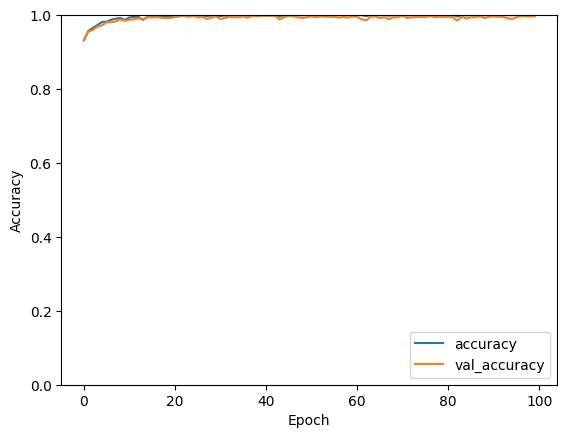

1.0 0.9965517520904541


In [16]:
# Plot accuracy
plt.figure()
plt.plot(train_accs, label='accuracy')
plt.plot(val_accs, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()
print(train_accs[-1], val_accs[-1])


In [20]:
test_str = "qazxswedcfrtgbnhyujmkiolpoiuytrewqasdfgh"
test_arr = np.array([str_to_neurons(sanitize_string(test_str)[:blockSize])])
print(test_arr)
test_tensor = torch.tensor(test_arr, dtype=torch.float32)
model.eval()
with torch.no_grad():
    pred = model(test_tensor)
    dane = torch.softmax(pred, dim=1)[0, :]
    print(f"Random {round(float(dane[0]), 6)}")
    print(f"Human {round(float(dane[1]), 6)}")

[[0.03125    0.03125    0.03125    0.03125    0.0625     0.03125
  0.03125    0.03125    0.0625     0.03125    0.03125    0.03125
  0.03125    0.03125    0.0625     0.03125    0.03125    0.0625
  0.03125    0.0625     0.0625     0.         0.03125    0.03125
  0.0625     0.03125    0.         0.11453071 0.124226   0.11111111
  0.124226   0.11453071 0.11111111 0.11453071 0.124226   0.124226
  0.11453071 0.11111111 0.11453071 0.124226   0.11111111 0.124226
  0.11453071 0.11111111 0.11453071 0.124226   0.124226   0.11453071
  0.11111111 0.11453071 0.13888889 0.11111111 0.11111111 0.11111111
  0.11111111 0.11111111 0.11111111 0.11111111]]
Random 0.0
Human 1.0


In [201]:
while True:
    from generate import generate_random
    test_str = generate_random(blockSize)
    test_arr = np.array([str_to_neurons(sanitize_string(test_str))])
    test_tensor = torch.tensor(test_arr, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        pred = model(test_tensor)
        dane = torch.softmax(pred, dim=1)[0, :]
        if dane[1] > dane[0]:
            print(f"Test string: {test_str}")
            print(test_arr)
            print(f"Random {round(float(dane[0]), 6)}")
            print(f"Human {round(float(dane[1]), 6)}")
            break


Test string: ehjlieihqiteruniejeafoceosfxrdei
[[0.03125    0.         0.03125    0.03125    0.21875    0.0625
  0.         0.0625     0.15625    0.0625     0.         0.03125
  0.         0.03125    0.0625     0.         0.03125    0.0625
  0.03125    0.03125    0.03125    0.         0.         0.03125
  0.         0.         0.         0.37781863 0.11111111 0.22222222
  0.17786456 0.55555556 0.55555556 0.2239516  0.59382106 0.77777778
  0.33333333 0.22222222 0.11111111 0.33333333 0.2239516  0.26205503
  0.55555556 0.48511803 0.48511803 0.2239516  0.33333333 0.53934688
  0.62422792 0.23733344 0.66666667 0.75818578 0.22222222 0.2003084
  0.26205503 0.13888889 0.11453071 0.55555556]]
Random 0.0
Human 1.0
